In [3]:
# Input:
path_data = '../01 data/shampoo.csv'

In [8]:
import  pandas as pd
from datetime import datetime
import  matplotlib.pyplot as plt

In [20]:
# Load data
data = pd.read_csv(path_data)

# Convert to datetime
def date_parser(x):
    return datetime.strptime('202'+x, '%Y-%m')
data['Month'] = data['Month'].apply(date_parser)

print(data.shape)
data.head()

(36, 2)


,Month,Sales
0,2021-01-01,266.0
1,2021-02-01,145.9
2,2021-03-01,183.1
3,2021-04-01,119.3
4,2021-05-01,180.3


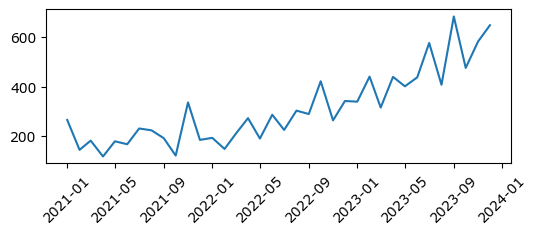

In [30]:
# Plot the time series
plt.figure(figsize=(6,2))
plt.plot(data['Month'], data['Sales'], linestyle='-')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Train test split
train = data.
val = 
test = 

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [74]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

In [43]:
# transform data to be stationary
diff_values = difference(data['Sales'].values, 1)
diff_values.head()

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64

In [44]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
supervised_values[:4]

array([[   0. , -120.1],
       [-120.1,   37.2],
       [  37.2,  -63.8],
       [ -63.8,   61. ]])

In [45]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [47]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
train_scaled[:5]

array([[-0.15241435, -0.80037766],
       [-0.80037766,  0.04828702],
       [ 0.04828702, -0.496628  ],
       [-0.496628  ,  0.17669274],
       [ 0.17669274, -0.21607769]])

In [48]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 2, 4)

In [73]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
predicted = lstm_model.predict(train_reshaped, batch_size=1)

23/23 [==============================] - 0s 2ms/step


In [54]:
print(len(predicted))
predicted[:5]

23


array([[-0.12405085],
       [-0.18712677],
       [-0.14081393],
       [-0.1855499 ],
       [-0.13875556]], dtype=float32)

In [55]:
test_scaled

array([[ 0.26733207, -0.16644187],
       [-0.16644187,  0.39088211],
       [ 0.39088211, -0.82411654],
       [-0.82411654,  0.51335312],
       [ 0.51335312, -0.35743189],
       [-0.35743189,  0.04235231],
       [ 0.04235231,  0.59266253],
       [ 0.59266253, -1.05826814],
       [-1.05826814,  1.32802806],
       [ 1.32802806, -1.26760183],
       [-1.26760183,  0.41947667],
       [ 0.41947667,  0.20151066]])

In [62]:
X = test_scaled[2, 0:-1]
X.reshape(1, 1, len(X))

array([[[ 0.39088211, -0.82411654]]])

In [66]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(data['Sales'].values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = data['Sales'][len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 20ms/step
Month=1, Predicted=366.872972, Expected=339.700000
1/1 [==============================] - 0s 28ms/step
Month=2, Predicted=362.406114, Expected=440.400000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=468.859916, Expected=315.900000
1/1 [==============================] - 0s 18ms/step
Month=4, Predicted=333.184473, Expected=439.300000
1/1 [==============================] - 0s 27ms/step
Month=5, Predicted=466.450116, Expected=401.300000
1/1 [==============================] - 0s 17ms/step
Month=6, Predicted=423.263900, Expected=437.400000
1/1 [==============================] - 0s 26ms/step
Month=7, Predicted=460.347173, Expected=575.500000
1/1 [==============================] - 0s 27ms/step
Month=8, Predicted=606.672204, Expected=407.600000
1/1 [==============================] - 0s 21ms/step
Month=9, Predicted=424.143665, Expected=682.000000
1/1 [==============================] - 0s 25ms/step
Month=10, Predicted=7

In [71]:
# report performance
rmse = mean_squared_error(data['Sales'].values[-12:], predictions)**0.5
print('Test RMSE: %.3f' % rmse)

Test RMSE: 138.969


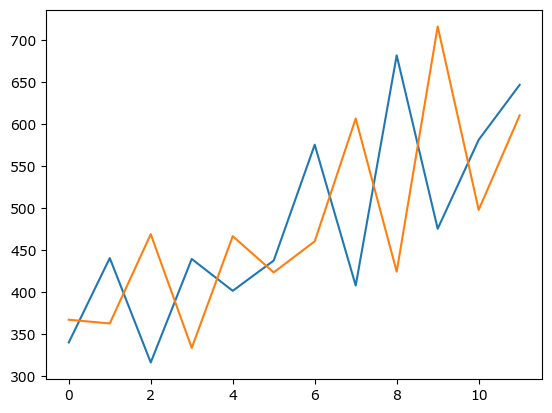

In [75]:
# line plot of observed vs predicted
plt.plot(data['Sales'].values[-12:])
plt.plot(predictions)
plt.show()